#### In this notebook I will practise the use RDKit

the docs were written in 2008

In [1]:
from rdkit import Chem
import numpy as np
import pandas as pd

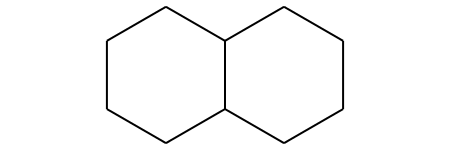

In [9]:
#creating molecule object:
molecule = Chem.MolFromSmiles('C1CCCC2C1CCCC2')
molecule

Read molecules, ForwardSDMolSuppliers for compressed ones; Write molecules

In [35]:
mols = Chem.SDMolSupplier('5ht3ligs.sdf')
for mol in mols:
    print(mol.GetNumAtoms())

compressedMolSet = Chem.ForwardSDMolSupplier('5ht3ligs.sdf')
with compressedMolSet as compSet:
    unpackedCompSet = [x for x in compSet]
print(unpackedCompSet[0].GetNumAtoms())
unpackedCompSet[0]


Chem.MolToSmiles(unpackedCompSet[0])

20
24
24
26
20


'CN1CCCCC1COC(=O)c1c[nH]c2ccccc12'

Creating MDL Blocks returns string objects. Converting them to say a Dataframe does need seem trivial

In [33]:
molec = Chem.MolFromSmiles(Chem.MolToSmiles(unpackedCompSet[0]))
print(Chem.MolToMolBlock(molec)[0:250]) #250 because the total string would be fairly long


     RDKit          2D

 20 22  0  0  0  0  0  0  0  0999 V2000
   -2.1491   -7.1273    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -3.5757   -7.5908    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0
   -3.8876   -9.0580    0.0000 C   0  0  0  0


I do not have a lot of experience in describing molecules based on spatial properties. Will look deeper into that, when it gets more relevant

In [84]:
with Chem.SDWriter('selfCreatedFile.sdf') as w:
    i=1
    for mol in mols:
        if i<3:
            i+=1
        else:
            mol.SetProp("_Name","Stefan's saved molecule: Every row is an Atom")
            w.write(mol)
            neighbors = mol.GetAtomWithIdx(0).GetNeighbors()
            print(neighbors[2].GetIdx())
            print("the atom at index 0 is: ",mol.GetAtomWithIdx(0).GetSymbol(),
                ".    its bond to its first neighbor is ",mol.GetBondBetweenAtoms(0,neighbors[0].GetIdx()).GetBondType())
            break

3
the atom at index 0 is:  C .    its bond to its first neighbor is  AROMATIC


Detailed information on ring properties are present
H-atoms can be added when need e.g. for spatial modelling

In [ ]:
m = Chem.MolFromSmiles('c1nccc2n1ccc2')
template=Chem.rdDepictor.Compute2DCoords(m)

Chem.rdDepictor.GenerateDepictionMatching2DStructure(m,template)

In [97]:
template = Chem.MolFromSmiles('c1nccc2n1ccc2')
Chem.rdDepictor.Compute2DCoords(template)

ms = [Chem.MolFromSmiles(smi) for smi in ('OCCc1ccn2cnccc12','C1CC1Oc1cc2ccncn2c1','CNC(=O)c1nccc2cccn12')]
for m in ms:
    print(Chem.rdDepictor.GenerateDepictionMatching2DStructure(m,template))
# idk how to make this graphs, lest 3D graphs

((0, 7), (1, 8), (2, 9), (3, 10), (4, 11), (5, 6), (6, 5), (7, 4), (8, 3))
((0, 10), (1, 9), (2, 8), (3, 7), (4, 6), (5, 11), (6, 12), (7, 4), (8, 5))
((0, 4), (1, 5), (2, 6), (3, 7), (4, 8), (5, 12), (6, 11), (7, 10), (8, 9))


Substructure searching <br>
SMARTS is a language to specify substrucre information in smiles <br><br>
chirality (stereochemistry i.e. mols with non-superimposable versions) are ignored by default but can be activated by useChirality=True

In [10]:
m = Chem.MolFromSmiles('c1ccccc1O')
m
pattern = Chem.MolFromSmarts("ccO") #can also use molfromsmiles here
print(m.HasSubstructMatch(pattern))
m.GetSubstructMatches(pattern)
#use for filtering lists of molecules to find specific substructures

True


((0, 5, 6), (4, 5, 6))

For simple chemical transformations rdkit has functionality, more complex ones should make use of the reactions library

In [15]:
from rdkit.Chem import AllChem

# removing substructure 
m = Chem.MolFromSmiles('CC(=O)O')
patt = Chem.MolFromSmarts('[OH]')
rm = AllChem.DeleteSubstructs(m,patt)
Chem.MolToSmiles(rm)

'CC=O'

In [16]:
m = Chem.MolFromSmiles('CC(=O)N')
replace = Chem.MolFromSmiles('OC')
patternn = Chem.MolFromSmarts('[$(NC(=O))]')

rms = AllChem.ReplaceSubstructs(m,patternn,replace)
Chem.MolToSmiles(rms[0]) # we replaced N with OC ... I cannot grasp from this why

'COC(C)=O'

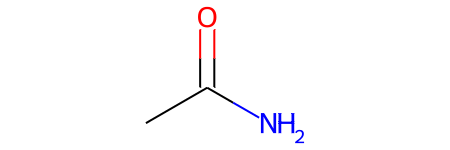

In [23]:
m

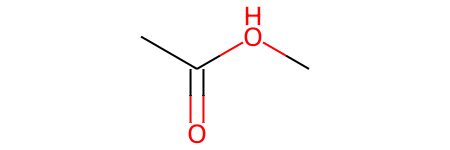

In [20]:
rms

we can also remove sidechains and cores

In [5]:
from rdkit.Chem import rdFMCS
mol1 = Chem.MolFromSmiles("O=C(NCc1cc(OC)c(O)cc1)CCCC/C=C/C(C)C")
mol2 = Chem.MolFromSmiles("CC(C)CCCCCC(=O)NCC1=CC(=C(C=C1)O)OC")
mol3 = Chem.MolFromSmiles("c1(C=O)cc(OC)c(O)cc1")
mols = [mol1,mol2,mol3]
res=rdFMCS.FindMCS(mols)
print(res.numAtoms)
res.smartsString # I don't understand this notion

10


'[#6]1(-[#6]):[#6]:[#6](-[#8]-[#6]):[#6](:[#6]:[#6]:1)-[#8]'

Fingerprinting

In [7]:
from rdkit import DataStructs
ms = [Chem.MolFromSmiles('CCOC'), Chem.MolFromSmiles('CCO'), Chem.MolFromSmiles('COC')]

fps = [Chem.RDKFingerprint(x) for x in ms]
print(DataStructs.FingerprintSimilarity(fps[0],fps[1]))
print(DataStructs.FingerprintSimilarity(fps[0],fps[2]))
print(DataStructs.FingerprintSimilarity(fps[1],fps[2]))


0.6
0.4
0.25


In [1]:
from rdkit.Chem import MACCSkeys
fps = [MACCSkeys.GenMACCSKeys(x) for x in ms]
print(DataStructs.FingerprintSimilarity(fps[0],fps[1]))
print(DataStructs.FingerprintSimilarity(fps[0],fps[2]))
print(DataStructs.FingerprintSimilarity(fps[1],fps[2])) #use this for similarity of drugs

NameError: name 'ms' is not defined

In [12]:
from rdkit import Chem
from rdkit.Chem.AtomPairs import Pairs
ms = [Chem.MolFromSmiles('C1CCC1OCC'),Chem.MolFromSmiles('CC(C)OCC'),Chem.MolFromSmiles('CCOCC')]
pairFps = [Pairs.GetAtomPairFingerprint(x) for x in ms]
pairFpsD = [x.GetNonzeroElements() for x in pairFps]
print(pairFpsD[1])
Pairs.ExplainPairScore(1606753) # C with 3 neighbours and 0 pi electrons 1 bond away from O with 2 neighbour and 0 pi e-

{541730: 1, 541732: 2, 558113: 1, 558115: 2, 574497: 2, 574499: 1, 574530: 1, 1606690: 3, 1606721: 1, 1606753: 1}


(('C', 3, 0), 1, ('O', 2, 0))

there are some different similarity functions one can try, but I believe for now it is sufficient to know that they exist, because the firstOwnRegression model has shown that it is not similarity what makes them work together

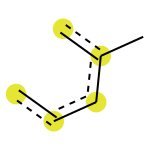

In [22]:
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
mol = Chem.MolFromSmiles('c1ccccc1CC1CC1')
bi = {}
fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, bitInfo=bi)
bi[872]
rdkbi = {}
rdkfp = Chem.RDKFingerprint(mol, maxPath=5, bitInfo=rdkbi)
rdk_svg = Draw.DrawRDKitBit(mol, 1553, rdkbi, useSVG=True)
rdk_svg

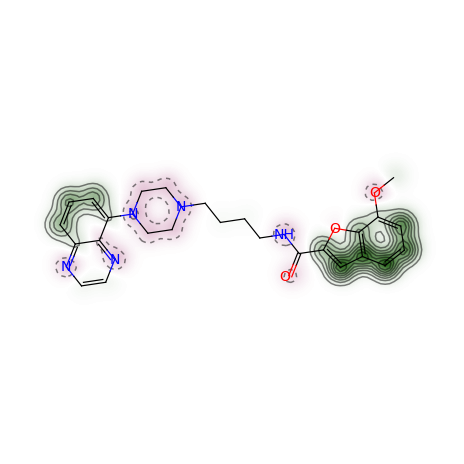

In [30]:
from rdkit.Chem.Draw import SimilarityMaps
mol = Chem.MolFromSmiles('COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21')
refmol = Chem.MolFromSmiles('CCCN(C)Cc1ccc2ccccc2c1')
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(refmol, mol, SimilarityMaps.GetMorganFingerprint)


Quite some descriptors are built into rdkit. Heres a list of them<br>
https://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-descriptors

one can use fingerprints to pick diverse molecules from a large set of molecules <br>
i'll do that in the ownRegression file, to get to a smaller set of elements